In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import json
import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx
import warnings

warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

f = open('/home/pi/twitter_api_creds.json')
creds = json.load(f)
consumer_key = creds['consumer_key']
consumer_secret = creds['consumer_secret']
access_token = creds['access_token']
access_token_secret = creds['access_token_secret']
f.close()

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [2]:
search_term = "#climate+change -filter:retweets"

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2018-11-01').items(1000)

all_tweets = [tweet.text for tweet in tweets]

all_tweets[:5]

['UK temperatures could regularly hit 40C by the end of the century, Met Office study warns\n\nSo little time to change… https://t.co/CieqAOllAd',
 '#Democrats #climate plan promises #netzero US #emissio by 2050 https://t.co/EUhmT9cdTB via @financialtimes Perhaps… https://t.co/01nkkeJVDD',
 'In Illinois, farmers adopt #conservation practices to increase soil health and curb long-term #climate effects. https://t.co/DPWSXXFp04',
 "I'm grateful to see a bold and detailed plan like this from the House Select Committee on the @ClimateCrisis.\n \nIt… https://t.co/4uI3dw8tzG",
 '“Through this new initiative, FCM’s Green Municipal Fund is enabling local action that can help achieve Canada’s… https://t.co/Q1W5qwZ67P']

In [16]:
#calls on text cleanup then removes the URL
def remove_url(txt):
    txt = clean(txt)
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
#Cleans up the text like newlines before url is removed.
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    return text

# # preprocessing speeches
# df['Speech_clean'] = df['Speech'].apply(clean)

In [19]:
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:5]

['UK temperatures could regularly hit 40C by the end of the century Met Office study warns So little time to change',
 'Democrats climate plan promises netzero US emissio by 2050 via financialtimes Perhaps',
 'In Illinois farmers adopt conservation practices to increase soil health and curb long term climate effects',
 'Im grateful to see a bold and detailed plan like this from the House Select Committee on the ClimateCrisis It',
 'Through this new initiative FCMs Green Municipal Fund is enabling local action that can help achieve Canadas']

In [20]:
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))
# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,climate,825
1,the,659
2,change,574
3,to,472
4,and,350


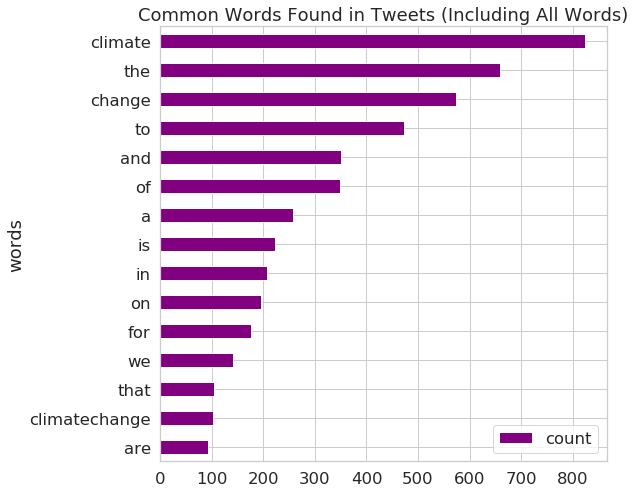

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

In [26]:
#removing stop words and further cleaning
nltk.download('stopwords')
#nltk.download('words')
stop_words = set(stopwords.words('english'))
#to get rid of error word that should not be english
#words = set(nltk.corpus.words.words())


tweets_nsw = [[word for word in tweet_words if not word in stop_words]
    for tweet_words in words_in_tweet]


all_words_nsw = list(itertools.chain(*tweets_nsw))
counts_nsw = collections.Counter(all_words_nsw)
counts_nsw.most_common(15)

[nltk_data] Downloading package stopwords to /home/pi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('climate', 825),
 ('change', 574),
 ('climatechange', 103),
 ('new', 63),
 ('amp', 59),
 ('us', 46),
 ('science', 41),
 ('global', 39),
 ('need', 38),
 ('world', 37),
 ('globalwarming', 36),
 ('environment', 33),
 ('government', 31),
 ('one', 29),
 ('time', 28)]

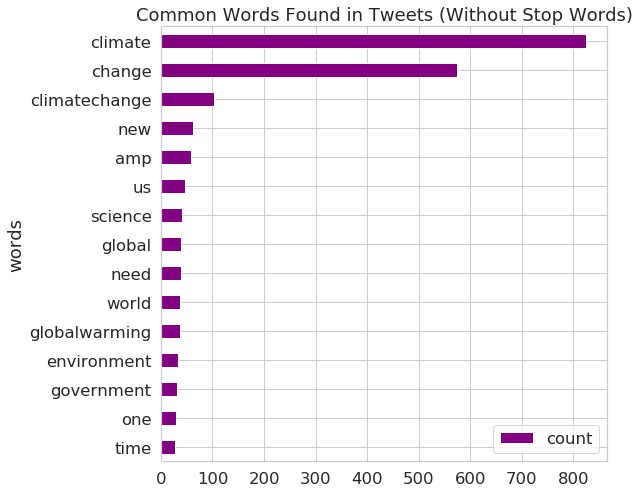

In [27]:
#Into DF and graphed most common words
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

In [28]:
#Removing search words as a sort of outlier handling
collection_words = ['climatechange', 'climate', 'change']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]


# Flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))
# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)
#One time instance of failure to clean should not show up
#I see now

[('new', 63),
 ('amp', 59),
 ('us', 46),
 ('science', 41),
 ('global', 39),
 ('need', 38),
 ('world', 37),
 ('globalwarming', 36),
 ('environment', 33),
 ('government', 31),
 ('one', 29),
 ('time', 28),
 ('podcast', 28),
 ('could', 26),
 ('covid', 26)]

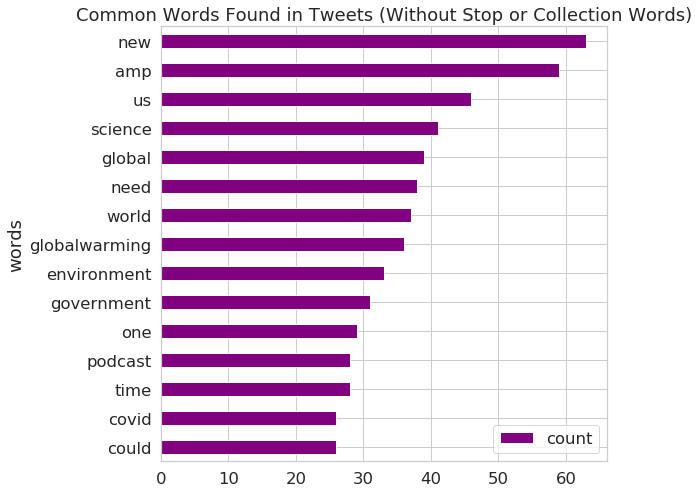

In [29]:
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

plt.show()
